In [18]:
import numpy as np
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve, gmres, lgmres
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spla

$$
\frac{V_{j}^{n+1}-V_{j}^{n}}{\Delta t}=r V_{j}^{n+1}-\frac{V_{j+1}^{n+1}-V_{j-1}^{n+1}}{2 \Delta S} r S-\frac{1}{2} \frac{V_{j-1}^{n+1}-2 V_{j}^{n+1}+V_{j+1}^{n+1}}{\Delta S^{2}} \sigma^{2} S^{2}
$$

显式格式为例

倒向方程

时间从后往前

注意右侧是非零的Dirichlet边界条件



In [19]:
class BS(object):
    # Initialization of constants 
    # -V_t + rV - rSV_s - 0.5sigma^2*S^2V_ss = 0
    # V(x,T) = VT
    # 
    def __init__(self, uT, r, sigma2, K, S, dt, T):
        self.sigma2 = sigma2
        self.uT = uT
        self.r = r 
        self.S = S   
        self.Ns = S.size
        self.ds = S[1]-S[0]
        self.dt = dt  
        self.T = T
        self.K = K
        self.t = np.arange(0, T+dt, dt)
        self.Nt = self.t.size
        self.sol = np.zeros((self.Nt, self.Ns))
        self.sol[-1,:] = self.uT

        # 一阶差分的矩阵，中心差分
        self.D1 = diags([-1,1],[-1,1],shape=(self.Ns,self.Ns))/(2*self.ds)

        # 二阶差分的矩阵
        self.D2 = diags([1,-2,1],[-1,0,1],shape=(self.Ns,self.Ns))/(self.ds**2)

        # r*S
        self.rS = diags(self.r*self.S)

        # sigma^2*S^2
        self.sigma2S2 = diags(self.sigma2*self.S**2)

    # linear operator for implicit method
    # 返回隐式格式的lhs matrix的linear operator
    def implicit_help(self):
        def lhs(v):
            vn = v - self.dt*(self.rS @ (self.D1 @ v) + 0.5*self.sigma2S2 @ (self.D2 @ v) - self.r*v)
            return vn
        return spla.LinearOperator((self.Ns, self.Ns), lhs)
    
    def SolveImplicit(self):
        Vn = np.copy(self.uT) # v in time tn+1
        V = np.copy(self.uT) # v in time tn
        M = self.implicit_help()
        for ti in range(self.Nt-2, -1, -1):
            V_max = self.S[-1] - K*np.exp(-self.r*(self.T-self.t[ti+1]))
            # 处理右边界
            Vn[-1] += self.dt*(self.r * self.S[-1] * V_max / (2*self.ds) + \
                0.5 * self.sigma2 * self.S[-1]**2 * V_max / (self.ds**2))
            # M*V = Vn
            V, exitCode = gmres(M, Vn)
            if exitCode != 0:
                raise Exception("not converge for gmres!")
            self.sol[ti,:] = V
            V, Vn = Vn, V
        return 


    # 显式格式
    def SolveExplicit(self):
        Vn = np.copy(self.uT) # u in time tn+1
        V = np.copy(self.uT) # u in time tn
        # Smax = self.S[-1] + self.ds
  
        for ti in range(self.Nt-2, -1, -1):
            # Vn_max = Vn[-2] + 2*self.ds
            Vn_max = self.S[-1] - K*np.exp(-self.r*(self.T-self.t[ti+1]))

            V[:] = Vn + self.dt*(self.rS @ (self.D1 @ Vn) + 0.5*self.sigma2S2 @ (self.D2 @ Vn) - self.r*Vn)
            V[-1] = Vn[-1] + self.dt*(self.r*self.S[-1]*(Vn_max-Vn[-2])/(2*self.ds) + 
                0.5*self.sigma2*self.S[-1]**2*(Vn[-2]-2*Vn[-1]+Vn_max)/(self.ds**2)-self.r*Vn[-1])
            self.sol[ti,:] = V
            V, Vn = Vn, V
        return 
    
    def plot(self):
        ti = [round(self.Nt*p) for p in [0.0, 0.2, 0.4, 0.6, 0.8]]
        ti.append(self.Nt-1)
        for i in ti:
            plt.plot(self.S, self.sol[i,:], label="t={:.3f}".format(self.t[i]))
        plt.legend()
        return

In [20]:
T=2
K=100
sigma2 = 0.09
r=0.04
S = np.linspace(0, 200, 50)
dt = 0.005
uT = np.maximum(S-K,0)
prob = BS(uT, r, sigma2, K, S, dt, T)
prob.SolveExplicit()

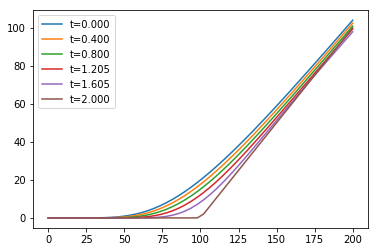

In [21]:
prob.plot()

In [27]:
T=2
K=100
sigma2 = 0.09
r=0.04
S = np.linspace(0, 200, 50)
dt = 0.2
uT = np.maximum(S-K,0)
prob = BS(uT, r, sigma2, K, S, dt, T)
prob.SolveImplicit()

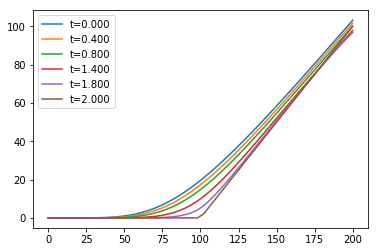

In [28]:
prob.plot()